# DuckDB + Parquet Data Exploration Template

In [40]:
from pathlib import Path
from tqdm import tqdm
import json
from IPython.display import display

import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors, ticker
from typing import Optional, Tuple
from matplotlib.cm import ScalarMappable
import folium
import matplotlib.dates as mdates
from random import shuffle

from src.gen_points_map import compute_step, make_equal_area_hex_grid, make_equal_area_grid
from src.geo_util import assign_intersection_id
from src.plotting.util import plot_gdf_column

import warnings
warnings.filterwarnings("ignore")  # hide every warning

# --- Configuration ---

In [30]:
BASE = Path("/Users/kyledorman/data/planet_coverage/ca_only/")  # <-- update this

# Example path patterns
f_pattern = "*/coastal_results/*/*/*/coastal_points.parquet"
all_files_pattern = str(BASE / f_pattern)

# Combined list used later when we search individual files
all_parquets = list(BASE.glob(f_pattern))

IDX = 1
hex_id = f"{IDX:06x}"  # unique 6‑digit hex, e.g. '0f1a2b'
d1, d2, d3 = hex_id[:2], hex_id[2:4], hex_id[4:6]
GRID_PATH = BASE / "dove" / "coastal_results" / d1 / d2 / d3
FILE = GRID_PATH / "coastal_points.parquet"

assert FILE.exists()

len(all_parquets)

56

In [65]:
display_crs = "EPSG:4326"
robinson_crs = "ESRI:54030"
sinus_crs = "ESRI:54008"

ca_ocean = gpd.read_file(BASE / "la.geojson")
query_df = gpd.read_file(BASE / "ocean_grids.gpkg")
grids_df = gpd.read_file(BASE / "coastal_grids.gpkg").rename(columns={"cell_id": "grid_id"})
heuristics_df = pd.read_csv(BASE / "simulated_tidal_coverage_heuristics.csv").set_index("cell_id")

cell_size_m = compute_step(0.5)
_, hex_grid = make_equal_area_hex_grid(cell_size_m, robinson_crs)
hex_grid = hex_grid.rename(columns={"cell_id": "hex_id"}).to_crs(display_crs)

cell_size_m = compute_step(2.0)
_, big_grid = make_equal_area_grid(cell_size_m, robinson_crs)
big_grid = big_grid.rename(columns={"cell_id": "square_id"}).to_crs(display_crs)

# Assign hex_id to query_df and grid_df
grids_df = assign_intersection_id(grids_df, hex_grid, "grid_id", "hex_id", sinus_crs)
query_df = assign_intersection_id(query_df, hex_grid, "cell_id", "hex_id", sinus_crs)

# Assign cell_id to grid_df
grids_df = assign_intersection_id(grids_df, query_df, "grid_id", "cell_id", sinus_crs)

# Assign square_id to grids_df
grids_df = assign_intersection_id(grids_df, big_grid, "grid_id", "square_id", sinus_crs)

# Add tidal information to grids_df and query_df
grids_df = grids_df.set_index("cell_id").join(heuristics_df, how='left').reset_index()
query_df = query_df.set_index("cell_id").join(heuristics_df, how='left').reset_index()

# Set plot crs
query_df = query_df.to_crs(display_crs)
grids_df = grids_df.to_crs(display_crs)
big_grid = big_grid.to_crs(display_crs)

# Set indexes
query_df = query_df.set_index("cell_id")
grids_df = grids_df.set_index("grid_id")
hex_grid = hex_grid.set_index("hex_id")
big_grid = big_grid.set_index("square_id")

# Filter grids to CA region
query_ca = query_df[query_df.geometry.intersects(ca_ocean.union_all())]
grids_ca = grids_df[grids_df.geometry.intersects(query_ca.union_all())]
hex_grid_ca = hex_grid[hex_grid.geometry.intersects(query_ca.union_all())]
big_grid_ca = big_grid[big_grid.geometry.intersects(query_ca.union_all())]

len(grids_ca), len(query_ca), len(hex_grid_ca), len(big_grid_ca)

(1556, 8, 48, 6)

In [37]:
centroid = ca_ocean.geometry[0].centroid
base_map = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, width=1000, height=800)

for idx, geo in enumerate(ca_ocean.geometry):
    folium.GeoJson(
        geo,
        name=str(idx),
        style_function=lambda feature: {
            "color": "white",
            "weight": 4,
        }
    ).add_to(base_map)

for gid, row in query_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "blue",
            "weight": 2,
        }
    ).add_to(base_map)

for gid, row in grids_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "green",
            "weight": 1,
        }
    ).add_to(base_map)

for gid, row in hex_grid_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "yellow",
            "weight": 1,
        }
    ).add_to(base_map)

for gid, row in big_grid_ca.iterrows():
    folium.GeoJson(
        row.geometry,
        popup=str(gid),
        style_function=lambda feature: {
            "color": "red",
            "weight": 1,
        }
    ).add_to(base_map)

# Display the map
base_map

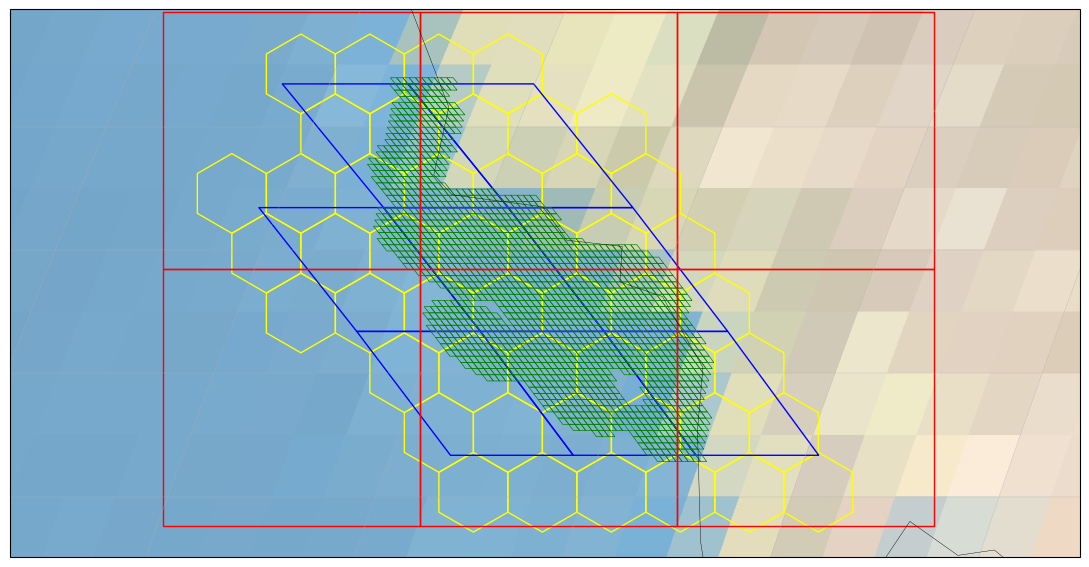

In [66]:
save_path = "/Users/kyledorman/data/planet_coverage/figs/ca_only/la_grids.png"
pad_fraction = 0.05

fig = plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Compute extent from data bounds (EPSG:4326) and add a small margin
xmin, ymin, xmax, ymax = hex_grid_ca.total_bounds
dx, dy = xmax - xmin, ymax - ymin
if dx == 0 or dy == 0:        # degenerate case (single point / line)
    dx = dy = max(dx, dy) or 1.0  # give it 1° span to avoid zero-width
pad_x = dx * pad_fraction
pad_y = dy * pad_fraction
ax.set_extent([xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y], crs=ccrs.PlateCarree())

# ------------------------------------------------------------------
# Plot data
# ------------------------------------------------------------------
hex_grid_ca.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    edgecolor="yellow",
    linewidth=1.0,
    facecolor="none",
)
query_ca.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    edgecolor="blue",
    linewidth=1.0,
    facecolor="none",
)
grids_ca.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    edgecolor="green",
    linewidth=0.5,
    facecolor="none",
)
big_grid_ca.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    edgecolor="red",
    linewidth=1.0,
    facecolor="none",
)

ax.coastlines(resolution="110m", linewidth=0.3)
ax.gridlines(draw_labels=False, linewidth=0.2)
ax.stock_img()

plt.tight_layout()
if save_path is not None:
    plt.savefig(save_path)
plt.show()

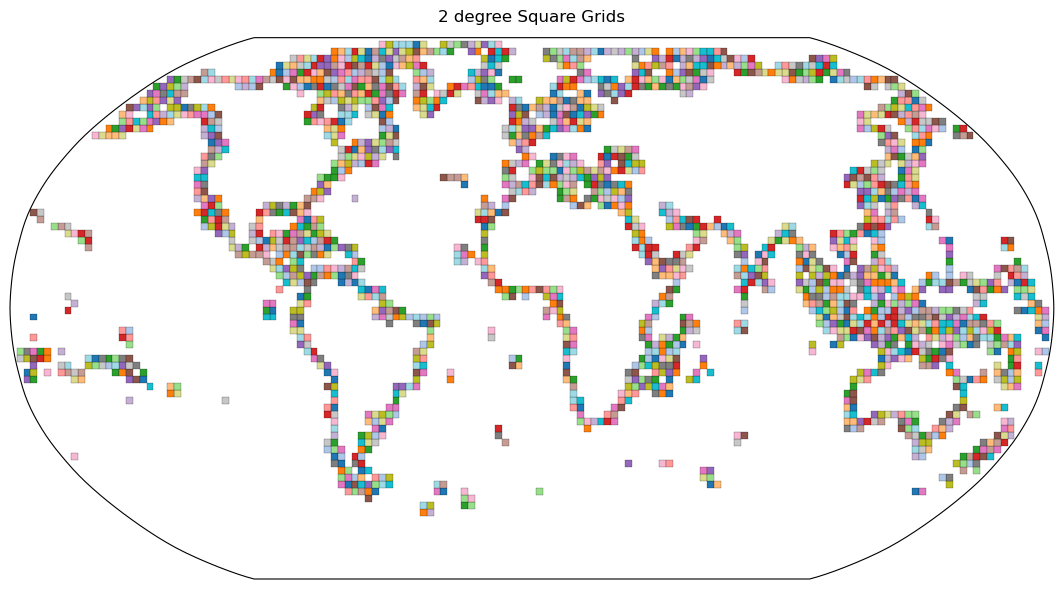

In [54]:
gdf = big_grid.loc[grids_df[grids_df.square_id >= 0].square_id.unique()][["geometry"]].copy()

ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf["id"].nunique()
base_cmap = plt.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)

plt.title("2 degree Square Grids", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/data/planet_coverage/figs/displays/degree_2_square.png")
plt.show()

KeyboardInterrupt: 

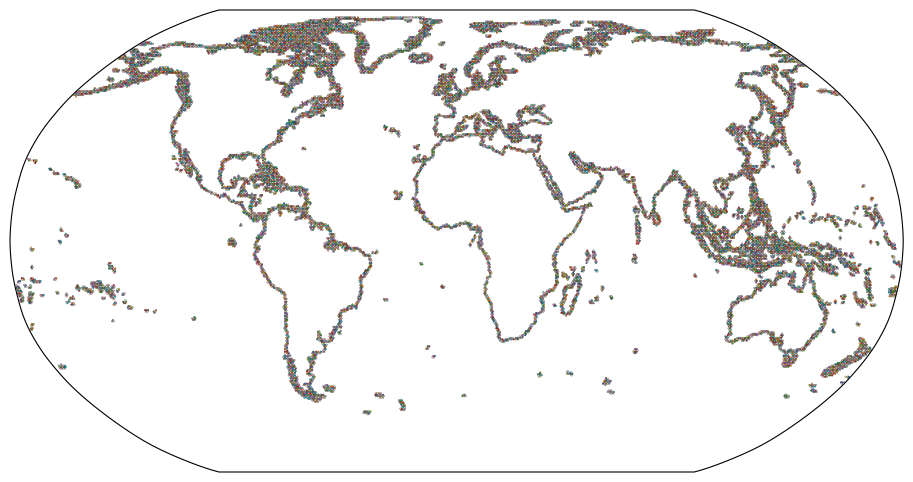

In [80]:
gdf = hex_grid.loc[grids_df[grids_df.hex_id >= 0].hex_id.unique()][["geometry"]].copy()

ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf["id"].nunique()
base_cmap = plt.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)
ax.stock_img()
plt.title("Query Grids", pad=12)
plt.tight_layout()
plt.savefig("/Users/kyledorman/data/planet_coverage/figs/displays/query_grids.png")
plt.show()

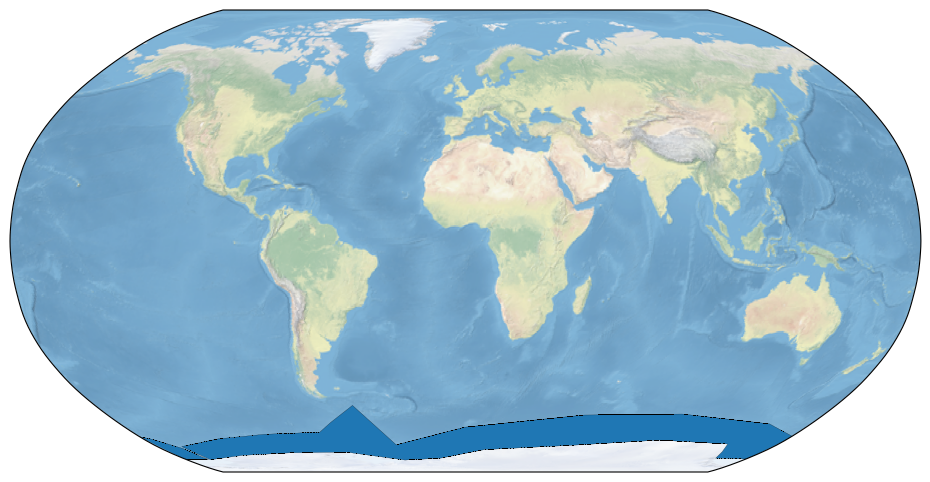

In [84]:
gdf = gpd.read_file("/Users/kyledorman/data/planet_coverage/shorelines/antarctica.geojson")
# gdf = hex_grid.loc[grids_df[grids_df.hex_id >= 0].hex_id.unique()][["geometry"]].copy()

ids = list(range(len(gdf)))
shuffle(ids)
gdf["id"] = ids

n_ids  = gdf["id"].nunique()
base_cmap = plt.get_cmap("tab20", n_ids)  # up to 20 unique colours
cmap      = colors.ListedColormap(base_cmap(range(n_ids)))
norm      = colors.BoundaryNorm(range(n_ids + 1), n_ids)

# Pick any Cartopy projection
proj = ccrs.Robinson()           # or ccrs.Mollweide(), ccrs.Robinson(), …

fig = plt.figure(figsize=(12, 6))
ax  = plt.axes(projection=proj)
ax.set_global()

# Re-project your data on the fly with `transform`
gdf.plot(
    column="id",
    ax=ax,
    cmap=cmap,
    norm=norm,
    linewidth=0.15,
    edgecolor="black",
    transform=ccrs.PlateCarree(),   # <- incoming lon/lat coords
)
ax.stock_img()
plt.show()

In [ ]:
# --- Connect to DuckDB ---
con = duckdb.connect()

In [ ]:
# Register a view for all files
con.execute(
    f"""
    CREATE OR REPLACE VIEW samples_all AS
    SELECT * FROM read_parquet('{all_files_pattern}');
"""
)

In [ ]:
# Register a view for a single file for faster iteration
con.execute(f"""
    CREATE OR REPLACE VIEW samples_one AS
    SELECT * FROM '{FILE}'
""")

In [ ]:
# --- Schema Inspection ---
print("Schema of samples_one:")
df = con.execute("DESCRIBE samples_one").fetchdf()
print(df)

In [ ]:
# --- NULL Check ---
print("Checking for NULL values:")
df_nulls = con.execute("""
    SELECT
        SUM(CASE WHEN id IS NULL THEN 1 ELSE 0 END) AS null_id,
        SUM(CASE WHEN acquired IS NULL THEN 1 ELSE 0 END) AS null_acquired,
        SUM(CASE WHEN item_type IS NULL THEN 1 ELSE 0 END) AS null_item_type,
        SUM(CASE WHEN satellite_id IS NULL THEN 1 ELSE 0 END) AS null_satellite_id,
        SUM(CASE WHEN instrument IS NULL THEN 1 ELSE 0 END) AS null_instrument,

        SUM(CASE WHEN cell_id IS NULL THEN 1 ELSE 0 END) AS null_cell_id,
        SUM(CASE WHEN grid_id IS NULL THEN 1 ELSE 0 END) AS null_grid_id,
        
        SUM(CASE WHEN has_8_channel IS NULL THEN 1 ELSE 0 END) AS null_has_8_channel,
        SUM(CASE WHEN has_sr_asset IS NULL THEN 1 ELSE 0 END) AS null_has_sr_asset,
        SUM(CASE WHEN clear_percent IS NULL THEN 1 ELSE 0 END) AS null_clear_percent,
        SUM(CASE WHEN quality_category IS NULL THEN 1 ELSE 0 END) AS null_quality_category,
        SUM(CASE WHEN ground_control IS NULL THEN 1 ELSE 0 END) AS null_ground_control,
        SUM(CASE WHEN publishing_stage IS NULL THEN 1 ELSE 0 END) AS null_publishing_stage,
        
        SUM(CASE WHEN satellite_azimuth IS NULL THEN 1 ELSE 0 END) AS null_satellite_azimuth,
        SUM(CASE WHEN sun_azimuth IS NULL THEN 1 ELSE 0 END) AS null_sun_azimuth,
        SUM(CASE WHEN sun_elevation IS NULL THEN 1 ELSE 0 END) AS null_sun_elevation,
        SUM(CASE WHEN view_angle IS NULL THEN 1 ELSE 0 END) AS null_view_angle,
        
        SUM(CASE WHEN tide_height IS NULL THEN 1 ELSE 0 END) AS null_tide_height,
        SUM(CASE WHEN has_tide_data IS NULL THEN 1 ELSE 0 END) AS null_has_tide_data,
        SUM(CASE WHEN tide_height_bin IS NULL THEN 1 ELSE 0 END) AS null_tide_height_bin,
        SUM(CASE WHEN coverage_pct IS NULL THEN 1 ELSE 0 END) AS null_coverage_pct,
        SUM(CASE WHEN intersects_grid_centroid IS NULL THEN 1 ELSE 0 END) AS null_intersects_grid_centroid,

        SUM(CASE WHEN geometry_wkb IS NULL THEN 1 ELSE 0 END) AS null_geometry_wkb,
    FROM samples_one
""").fetchdf()
df_nulls

In [ ]:
cols = ['item_type', 'instrument', 'has_8_channel ', 'has_sr_asset', 'quality_category', 'ground_control', 'publishing_stage']
for col in cols:
    df = con.execute(f"SELECT DISTINCT {col} from samples_all").fetchdf()
    display(df.head())

In [ ]:
# --- Preview Data ---
df_preview = con.execute("SELECT * FROM samples_one LIMIT 5").fetchdf()
df_preview

In [ ]:
# --- Filter By Time ---
df_2024 = con.execute("""
    SELECT *
    FROM samples_one
    WHERE acquired >= '2024-01-01' AND acquired < '2025-01-01'
    LIMIT 100
""").fetchdf()
df_2024.head(5)

In [ ]:
df_dates = con.execute("""
    SELECT 
        grid_id, 
        cell_id,
        MIN(acquired) as first_sample,
        MAX(acquired) as last_sample
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id, cell_id
""").fetchdf().set_index("grid_id")

print(df_dates.first_sample.min(), df_dates.first_sample.max())
print(df_dates.last_sample.min(), df_dates.last_sample.max())
print(len(df_dates), len(grids_df))
print(len(df_dates.cell_id.unique()), len(query_df))

In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

plot_gdf_column(geo_plot, "sample_count", title="Sample Count PSScene", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

df = pd.DataFrame(geo_plot.groupby("hex_id")["sample_count"].sum())
df = df[df.index >= 0]
df = df.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "sample_count", title="Sample Count PSScene Hex", show_coastlines=True)

In [ ]:
df = pd.DataFrame(grids_df.groupby("hex_id")["dist_km"].median())
df = df[df.index >= 0]
df = df.join(hex_grid[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "dist_km", title="dist_km", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

# Sample count per grid cell
df_counts = con.execute("""
    SELECT grid_id, COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    AND coverage_pct > 0.5
    AND publishing_stage = 'finalized'
    AND quality_category = 'standard'
    AND has_sr_asset
    AND ground_control
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

geo_plot = grids_ca.join(df_counts, how="left").fillna({"sample_count": 0})

df = pd.DataFrame(geo_plot.groupby("hex_id")["sample_count"].sum())
df = df[df.index >= 0]
df = df.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(df, geometry="geometry")

plot_gdf_column(gdf, "sample_count", title="High Quality Sample Count", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df = con.execute(
    """
    SELECT grid_id, SUM(coverage_pct > 0.5)::DOUBLE AS coverage_count,  COUNT(*) as sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_coverage = grids_ca.join(df, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% Greater than 50% coverage", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% Greater than 50% coverage", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE as coverage_count,
           COUNT(*) AS sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_coverage = grids_ca.join(df_pct, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% Intersects Grid Center", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% Intersects Grid Center", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE  / SUM(coverage_pct > 0.5)::DOUBLE AS frac_coverage
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_pct = grids_ca.join(df_pct, how="left").fillna({"frac_coverage": 0.0})

plot_gdf_column(geo_pct, "frac_coverage", title="Ration grid center vs 50% coverage", show_coastlines=True)

In [ ]:
# --- Load Geo Points and Join ---

df_pct = con.execute(
    """
    SELECT grid_id,
           SUM(intersects_grid_centroid)::DOUBLE  / SUM(coverage_pct > 0.75)::DOUBLE AS frac_coverage
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY grid_id
"""
).fetchdf().set_index("grid_id")

geo_pct = grids_ca.join(df_pct, how="left").fillna({"frac_coverage": 0.0})

plot_gdf_column(geo_pct, "frac_coverage", title="Ration grid center vs 75% coverage", show_coastlines=True)

In [ ]:
df_cov = con.execute("""
    SELECT
        grid_id,
        COUNT(*)                                                  AS sample_count,
        SUM(CASE WHEN coverage_pct > 0.5 THEN 1 ELSE 0 END)      AS coverage_count,
    FROM samples_all
    WHERE item_type        = 'PSScene'
      AND publishing_stage = 'finalized'
      AND quality_category = 'standard'
      AND has_sr_asset
      AND ground_control
    GROUP BY grid_id
""").fetchdf().set_index("grid_id")

# join with your coastal grid GeoDataFrame
geo_coverage = grids_ca.join(df_cov, how="left").fillna({"sample_count": 1.0, "coverage_count": 0.0})
geo_coverage["sample_pct"] = geo_coverage.coverage_count / geo_coverage.sample_count 

plot_gdf_column(geo_coverage, "sample_pct", title="% of high quality captures with >50 % area", show_coastlines=True)

agg = (
    geo_coverage.groupby('hex_id', as_index=False, sort=False)[['coverage_count', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          coverage_pct=lambda d: d['coverage_count'] / d['sample_count']  # or * 100 for %
      )
)
agg = agg.set_index("hex_id")[agg.index >= 0]
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "coverage_pct", title="% of high quality captures with >50 % area", show_coastlines=True)

In [ ]:
# ---- Histogram Per Day Counts (w/Publish Stage) ---- #

# 1. Pull per-day counts broken out by stage
df_stage = con.execute("""
    SELECT
        date_trunc('day', acquired) AS day,
        publishing_stage,
        COUNT(DISTINCT id) AS cnt
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY day, publishing_stage
    ORDER BY day
""").fetchdf()

# 2. Normalize day column and pivot so each stage is its own column
df_stage['day'] = pd.to_datetime(df_stage['day']).dt.date
df_pivot = (
    df_stage
    .pivot(index='day', columns='publishing_stage', values='cnt')
    .fillna(0)
)

# 3. Ensure a consistent stack order
stages = ['preview', 'finalized', 'standard']
df_pivot = df_pivot.reindex(columns=stages, fill_value=0)

# 4. Plot stacked bars
fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(df_pivot))

for stage in stages:
    ax.bar(
        df_pivot.index.astype(str),
        df_pivot[stage],
        bottom=bottom,
        label=stage
    )
    bottom += df_pivot[stage].values

ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
ax.set_title("Sample Count per Day by Publishing Stage")
ax.set_xlabel("Day")
ax.set_ylabel("Sample Count")
ax.legend(title="Publishing Stage")
fig.tight_layout()
plt.show()

In [ ]:
def compute_minmax(column: str) -> pd.DataFrame:
    sql = f"""
        SELECT
        MIN({column}) AS minv,
        MAX({column}) AS maxv
        FROM samples_all
        WHERE item_type = 'PSScene'
    """
    return con.execute(sql).fetchdf()

def compute_histogram(column: str, nbins: int = 30) -> pd.DataFrame:
    """
    Runs DuckDB's histogram() table function on `column` in samples_all (filtered to PSScene)
    and returns a DataFrame with columns: bin_upper, frequency.
    """
    sql = f"""
        WITH bounds AS (
          SELECT
            MIN({column}) AS mn,
            MAX({column}) AS mx
          FROM samples_all
          WHERE item_type = 'PSScene'
        )
        SELECT
          -- histogram() returns a MAP<upper_boundary, count>
          histogram(
            {column},
            equi_width_bins(bounds.mn::DOUBLE, bounds.mx::DOUBLE, {nbins}::BIGINT, True)
          ) AS hist_map
        FROM samples_all
        CROSS JOIN bounds
        WHERE item_type = 'PSScene';
    """
    hist_map = con.execute(sql).fetchdf().iloc[0]["hist_map"]

    
    # Unpack into a two-column DataFrame
    df = pd.DataFrame({
        'bin_upper': list(hist_map.keys()),
        'count':     list(hist_map.values())
    })
    df = df.sort_values('bin_upper').reset_index(drop=True)
    uppers = df['bin_upper'].tolist()
    bin_size = uppers[1] - uppers[0]
    # Compute lower edge from previous upper
    lowest = uppers[0] - bin_size
    lowers = [lowest] + uppers[:-1]
    df["bin_lower"] = pd.Series(lowers)
    df["centers"] = (df["bin_lower"] + df['bin_upper']) / 2
    df["widths"]  = df['bin_upper'] - df["bin_lower"]
    return df

In [ ]:
# Set up a 2×2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()


# 2. Plotting all four angle columns
for ax, col in zip(axes, ["satellite_azimuth", "sun_azimuth", "sun_elevation", "view_angle"]):
    df_hist = compute_histogram(col, nbins=30)

    ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
    ax.set_title(f"Histogram of {col.replace('_',' ').title()}")
    ax.set_xlabel(col.replace('_',' ').title())
    ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

In [ ]:
# --- Histogram of Sample Count per Month ---
df_monthly = con.execute("""
    SELECT date_trunc('month', acquired) AS month, COUNT(DISTINCT id) AS sample_count
    FROM samples_all
    WHERE item_type = 'PSScene'
    GROUP BY month
    ORDER BY month
""").fetchdf()

# Plot histogram
plt.figure(figsize=(10,4))
plt.bar(df_monthly['month'].astype(str), df_monthly['sample_count'])
plt.xticks(rotation=45, ha='right')
plt.title("Sample Count per Month (Unique Scenes)")
plt.xlabel("Month")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

In [ ]:
# --- Histogram of coverage_pct ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

df_hist = compute_histogram("coverage_pct", nbins=10)

ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
ax.set_title(f"Histogram of {'coverage_pct'.title()}")
ax.set_xlabel("coverage_pct".title())
ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

In [ ]:
# --- Histogram of clear_percent ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

df_hist = compute_histogram("clear_percent", nbins=30)

ax.bar(df_hist["centers"], df_hist['count'], width=df_hist["widths"] * 0.9)
ax.set_title(f"Histogram of {'clear_percent'.title()}")
ax.set_xlabel("clear_percent".title())
ax.set_ylabel("Frequency")
    
fig.tight_layout()
plt.show()

In [ ]:
query = """
SELECT
    grid_id,
    MIN(tide_height) AS obs_min_tide_height,
    MAX(tide_height) AS obs_max_tide_height
FROM samples_all
WHERE
    acquired >= TIMESTAMP '2023-12-01'
    AND acquired <  TIMESTAMP '2025-01-01'
    AND item_type        = 'PSScene'
    AND publishing_stage = 'finalized'
    AND quality_category = 'standard'
    AND has_sr_asset
    AND ground_control
    AND has_tide_data
GROUP BY grid_id
ORDER BY grid_id;
"""

df = con.execute(query).fetchdf().set_index("grid_id")

geo_tide = grids_ca.join(df, how="left").dropna(subset=["obs_min_tide_height", "obs_max_tide_height", 'tide_range'])
geo_tide['obs_tide_range'] = geo_tide.obs_max_tide_height - geo_tide.obs_min_tide_height
geo_tide['phase_coverage'] = geo_tide['obs_tide_range'] / geo_tide['tide_range']
plot_gdf_column(geo_tide, "phase_coverage", title="phase_coverage", show_coastlines=True)

hex_tide = (
    geo_tide
      .groupby("hex_id")
      .agg(                 # keep one row per hex_id
          obs_min_tide_height=("obs_min_tide_height", "min"),   # lowest observed tide
          obs_max_tide_height=("obs_max_tide_height", "max"),   # highest observed tide
          tide_min=("tide_min", "min"),   # lowest tide
          tide_max=("tide_max", "max"),   # highest tide
      )
)
hex_tide['tide_range'] = hex_tide.tide_max - hex_tide.tide_min
hex_tide['obs_tide_range'] = hex_tide.obs_max_tide_height - hex_tide.obs_min_tide_height
hex_tide['phase_coverage'] = hex_tide.obs_tide_range / hex_tide.tide_range

hex_tide = hex_tide[hex_tide.index >= 0]
hex_tide = hex_tide.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(hex_tide, geometry="geometry")

plot_gdf_column(gdf, "phase_coverage", title="phase_coverage", show_coastlines=True)

In [ ]:
query = """
-- one row per grid_id × calendar-month
SELECT
    grid_id,
    /* month_start = first day of the month, keeps it sortable & readable */
    DATE_TRUNC('month', acquired) AS month_start,
    COUNT(*)                       AS sample_count,
    COUNT_IF(has_8_channel)        AS count_8_channel      -- rows where flag = TRUE
FROM samples_all
WHERE
    item_type        = 'PSScene'
    AND coverage_pct > 0.5
GROUP BY grid_id, month_start
ORDER BY grid_id, month_start;
"""

monthly_counts = con.execute(query).fetchdf().set_index("grid_id")
monthly_counts["pct_8_channel"] = monthly_counts.count_8_channel / monthly_counts.sample_count
monthly_counts

In [ ]:
monthly_counts.loc[12487145].plot.scatter(y="pct_8_channel", x="month_start")

In [ ]:
monthly_counts.loc[12487145].plot.scatter(y="sample_count", x="month_start")

In [ ]:
first_month_8_channel = monthly_counts[monthly_counts.pct_8_channel > 0.5].reset_index().drop_duplicates(subset=["grid_id"]).set_index("grid_id")
first_month_8_channel

In [ ]:
geo_tide = grids_ca.join(first_month_8_channel[["month_start"]], how="left").dropna(subset=['month_start'])
plot_gdf_column(geo_tide, "month_start", title="month_start", show_coastlines=True)

In [ ]:
hex_counts = grids_ca[["hex_id"]].join(monthly_counts, how='left')

agg = (
    hex_counts.groupby(['hex_id', 'month_start'], as_index=False, sort=False)[['count_8_channel', 'sample_count']]
      .sum()                                # ← sums within each hex
      .assign(
          pct_8_channel=lambda d: d['count_8_channel'] / d['sample_count']  # or * 100 for %
      )
)

agg = agg[agg.index >= 0]
agg = agg[agg.pct_8_channel > 0.5].reset_index().drop_duplicates(subset=["hex_id"]).set_index("hex_id")
agg = agg.join(hex_grid_ca[["geometry"]])
gdf = gpd.GeoDataFrame(agg, geometry="geometry")

plot_gdf_column(gdf, "month_start", title="month_start", show_coastlines=True)

In [64]:
from PIL import Image

image_paths = sorted(list(Path("/Users/kyledorman/data/planet_coverage/figs/points_30km/days_with_sample/").glob("max_*valid*")))[:-1]

def make_gif(image_paths):
    frames = [Image.open(image) for image in image_paths]
    frame_one = frames[0]
    frame_one.save("/Users/kyledorman/data/planet_coverage/figs/points_30km/days_with_sample/max_days_with_sample_valid.gif", format="GIF", append_images=frames,
               save_all=True, duration=700, loop=0)
    
make_gif(image_paths)
